# Using Amazon SageMaker to Clone Driving Behavior
## Introduction
This Notebook is a prototype for a Level 300-400 re:Invent 2018 Hackathon where participants will perform the following:

1. Drive a vehicle on a mock track using a [Self-Driving Car Simulator](https://github.com/udacity/self-driving-car-sim) to capture the vehicle's telemetry.
2. Create a Machine Learning (ML) Pipeline, using the telemetry data, to clone the driving behavior as part of a Deep Learning model.
3. Deploy the behavioral cloning model to a production SageMaker Inference Endpoint.
4. Use the Endpoint to autonomously drive the vehicle around a second mock track.

In [1]:
# Suggested Libraries for conda_mxnet
import warnings
import zipfile
import os
#from tqdm import tqdm_notebook
import boto3
import sagemaker
import cv2
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from utils import INPUT_SHAPE, batch_generator
from IPython.display import display
from sklearn.model_selection import train_test_split
warnings.simplefilter('ignore')
%matplotlib inline

# Configure SageMaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


---
## Data Exploration
### Sample Dataset
[sample dataset](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)

In [2]:
# Download and extract Sample Data
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip'
r = requests.get(url)
with open("data.zip", "wb") as file:
    file.write(r.content)
with zipfile.ZipFile("data.zip") as zf:
    zf.extractall()

In [3]:
data_df = pd.read_csv('./data/driving_log.csv')
data_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


### Data Exploration

In [4]:
# Data Overview
print("Dataset Shape: {}".format(data_df.shape))
print(data_df.describe())

Dataset Shape: (8036, 7)
          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


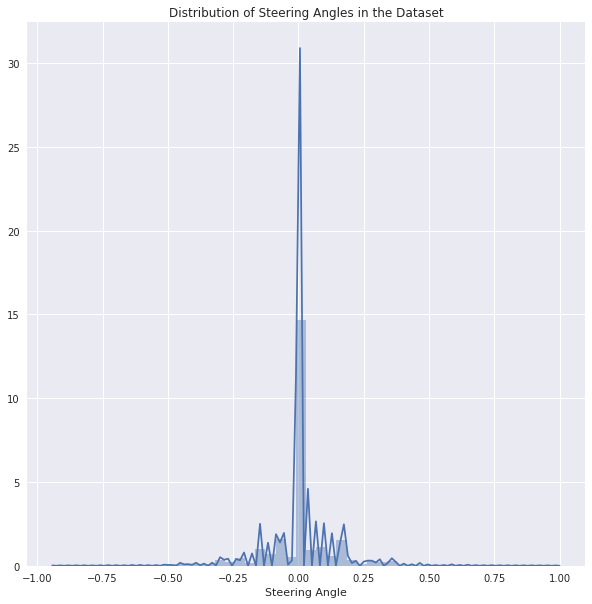

In [5]:
# Visualize the distribution of the data
sns.set(rc={'figure.figsize':(10, 10)})
fig = sns.distplot(data_df.steering)
plt.xlabel("Steering Angle")
plt.title("Distribution of Steering Angles in the Dataset")
plt.show(fig);

The Sample Dataset is skewed toward the zero steering angle and therefore more training data will need to be added during the Data Preprocessing step.

---
## Data Preprocesing
### Feature Extraction

In [6]:
# Separate the features
X = data_df[['center', 'left', 'right']].values
y = data_df['steering'].values

### Image Shape
1. Crop images for Region of Interest (ROI)
2. Resize images to $66 \times 200 \times 3$ (YUV Channels)

In [7]:
# Image Shape Preprocessing
def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front

In [8]:
def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

In [9]:
def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

### Image Augmentation
- Randomly choose right, left or center images.
- For left image, steering angle is adjusted by +0.2
- For right image, steering angle is adjusted by -0.2
- Randomly flip image left/right
- Randomly translate image horizontally with steering angle adjustment (0.002 per pixel shift)
- Randomly translate image virtically
- Randomly added shadows
- Randomly altering image brightness (lighter or darker)

In [10]:
# Randomly Flip image Left/Right
def random_flip(image, steering_angle):
    """
    Randomly flit the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

In [11]:
# Randomly Translate Vertically and Horizontally
def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

In [12]:
# Radomly Adjust Brightness
def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [13]:
def load_image(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

def choose_image(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.2
    return load_image(data_dir, center), steering_angle

def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image

### Augmented Image Examples

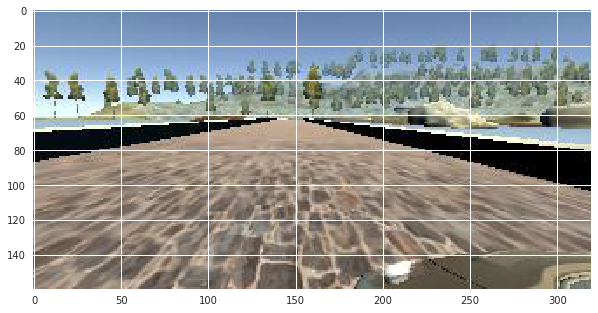

In [14]:
# Origional 'left' image
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
random_image = X[100][1]
img = load_image('data', random_image)
plt.imshow(img);

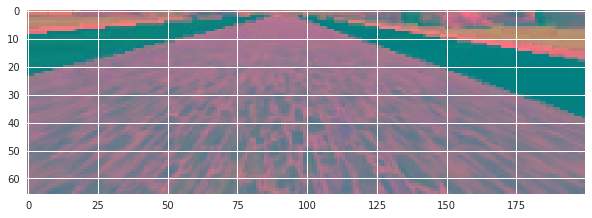

In [15]:
# Preprocessed "original" image
plt.imshow(preprocess(img));

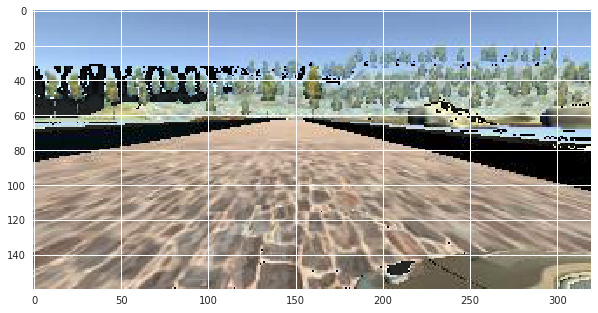

In [16]:
# Add Random brightness
plt.imshow(random_brightness(img));

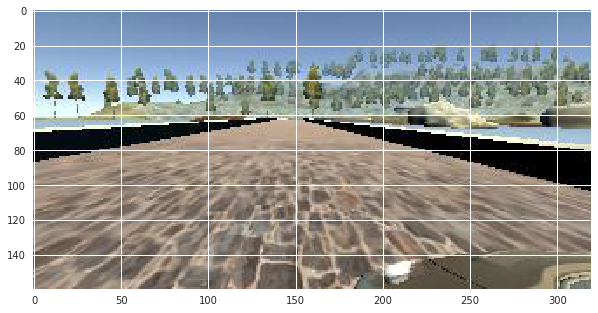

In [17]:
# Flip
plt.imshow(random_flip(img, 0)[0]);

### Training and Validation Dataset
Create the Training and Vlaidation Datasets using a 90/10 split respectivley. There is no Test Dataset as the final test will be acomplished using the Simulator.

In [18]:
# Batch Image Generator
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose_image(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_brightness(image)
    return image, steering_angle

def data_generator(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.9:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load_image(data_dir, center) 
            # add the image and steering angle to the batch
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        return images, steers

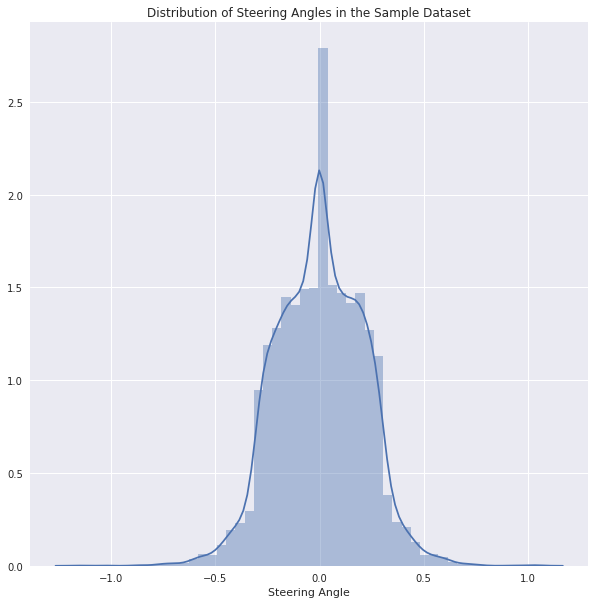

In [19]:
images, angle = data_generator('data', X, y, len(X), True)
fig = sns.distplot(angle)
plt.xlabel("Steering Angle")
plt.title("Distribution of Steering Angles in the Sample Dataset")
plt.show(fig);

As can be seen from the sample datatset, the disribution of steering angles is more uniform. Next we create the datasets for the model.

In [20]:
# Create Training and Validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(images, angle, test_size=0.1, random_state=0)

In [21]:
#X_train = np.array(X_train)
#y_train = y_train.reshape(y_train.shape[0], 1)
#y_valid = y_valid.reshape(y_valid.shape[0], 1)

---
## Model Architecture and Training
[End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/deep-learning-self-driving-cars/)
![Architecture](https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture-624x890.png)

In [22]:
# Build the keras model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24, 5, strides=(4, 4), padding='same', activation='elu'))
model.add(Conv2D(36, 5, strides=(2, 2), padding='same', activation='elu'))
model.add(Conv2D(48, 5, strides=(2, 2), padding='same', activation='elu'))
model.add(Conv2D(64, 3, activation='elu'))
model.add(Conv2D(64, 3, activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1164, activation='elu'))
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 50, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 25, 36)         21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 13, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 11, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 9, 64)          36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 9, 64)          0         
__________

In [ ]:
checkpoint = ModelCheckpoint(
    'model-{epoch:03d}.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only='true',
    mode='auto'
)

In [ ]:
checkpoint = model.compile(loss='mean_squared_error', optimizer=Adam(lr=1.0e-4))

In [ ]:
model.fit_generator(
    batch_generator('data', X_train, y_train, 256, True),
    steps_per_epoch=20000,
    epochs=10,
    initial_epoch=0,
    validation_data=batch_generator('data', X_valid, y_valid, 256, False),
    validation_steps=len(X_valid),
    callbacks=[checkpoint],
    verbose=1
)

In [ ]:
def load_data(args):
    """
    Load training data and split it into training and validation set
    """
    data_df = pd.read_csv(os.path.join(args.data_dir, 'driving_log.csv'))

    X = data_df[['center', 'left', 'right']].values
    y = data_df['steering'].values

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=args.test_size, random_state=0)

    return X_train, X_valid, y_train, y_valid


In [ ]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Flatten, Lambda, Activation, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam

import helper

#tf.python.control_flow_ops = tf

number_of_epochs = 8
number_of_samples_per_epoch = 20032
number_of_validation_samples = 6400
learning_rate = 1e-4
activation_relu = 'relu'

# Our model is based on NVIDIA's "End to End Learning for Self-Driving Cars" paper
# Source:  https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
model = Sequential()

model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(64, 64, 3)))

# starts with five convolutional and maxpooling layers
model.add(Conv2D(24, 5, padding='same', strides=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Conv2D(36, 5, padding='same', strides=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Conv2D(48, 5, padding='same', strides=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Conv2D(64, 3, padding='same', strides=(1, 1)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Conv2D(64, 3, padding='same', strides=(1, 1)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Flatten())

# Next, five fully connected layers
model.add(Dense(1164))
model.add(Activation(activation_relu))

model.add(Dense(100))
model.add(Activation(activation_relu))

model.add(Dense(50))
model.add(Activation(activation_relu))

model.add(Dense(10))
model.add(Activation(activation_relu))

model.add(Dense(1))

model.summary()

model.compile(optimizer=Adam(learning_rate), loss="mse", )

# create two generators for training and validation
train_gen = helper.generate_next_batch()
validation_gen = helper.generate_next_batch()

history = model.fit_generator(train_gen,
                              steps_per_epoch=number_of_samples_per_epoch,
                              epochs=number_of_epochs,
                              validation_data=validation_gen,
                              validation_steps=number_of_validation_samples,
                              verbose=1)

# finally save our model and weights
helper.save_model(model)

---
## Model Optimization and Analysis

---
## Production Deployment